In [1]:

import time
import torch
import sys
## Adding PyGRANSO directories. Should be modified by user
sys.path.append('/home/buyun/Documents/GitHub/PyGRANSO')
from pygranso import pygranso
from pygransoStruct import pygransoStruct 
from private.getNvar import getNvarTorch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision


# ## Data Initialization 
# Specify torch device, neural network architecture, and generate data.
# 
# NOTE: please specify path for downloading data.
# 
# Use GPU for this problem. If no cuda device available, please set *device = torch.device('cpu')*

# In[2]:


device = torch.device('cuda')

class Net(nn.Module):
     def __init__(self):
             super().__init__()
             self.conv1 = nn.Conv2d(3, 6, 5)
             self.conv1_bn = nn.BatchNorm2d(6)
             self.pool = nn.MaxPool2d(2, 2)
             self.conv2 = nn.Conv2d(6, 8, 9)
             self.conv2_bn = nn.BatchNorm2d(8)
             self.fc1 = nn.Linear(8 * 3 * 3, 30)
             self.fc1_bn = nn.BatchNorm1d(30)
             self.fc2 = nn.Linear(30, 20)
             self.fc2_bn = nn.BatchNorm1d(20)
             self.fc3 = nn.Linear(20, 10)

     def forward(self, x):
             x = self.pool(F.elu( self.conv1_bn(self.conv1(x))  ))
             x = self.pool(F.elu( self.conv2_bn(self.conv2(x))  ))
             x = torch.flatten(x, 1) # flatten all dimensions except batch
             x = F.elu( self.fc1_bn(self.fc1(x)) )
             x = F.elu( self.fc2_bn(self.fc2(x)) )
             x = self.fc3(x)
             return x

# fix model parameters
torch.manual_seed(0)
model = Net().to(device=device, dtype=torch.double)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 1000
trainset = torchvision.datasets.CIFAR10(root='/home/buyun/Documents/GitHub/PyGRANSO/examples', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
# data_in
for i, data in enumerate(trainloader, 0):        
    if i >= 1:
         break   
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    
# All the user-provided data (vector/matrix/tensor) must be in torch tensor format. 
# As PyTorch tensor is single precision by default, one must explicitly set `dtype=torch.double`.
# Also, please make sure the device of provided torch tensor is the same as opts.torch_device.
labels = labels.to(device=device) # label/target [256]
inputs = inputs.to(device=device, dtype=torch.double) # input data [256,3,32,32]


# ## Function Set-Up
# 
# Encode the optimization variables, and objective and constraint functions.
# 
# Note: please strictly follow the format of comb_fn, which will be used in the PyGRANSO main algortihm.

# In[3]:


# variables and corresponding dimensions.
var_in = {}
var_count = 0
var_str = "x"
for i in model.parameters():
    # print(i.shape)
    var_in[var_str+str(var_count)]= list(i.shape)
    var_count += 1
    
def user_fn(X_struct,model,inputs,labels):
    # objective function
    var_str = "x"
    var_count = 0
    for p in model.parameters():
        tmpstr = var_str+str(var_count)
        tmp_parameter = getattr(X_struct,tmpstr)
        p.data = tmp_parameter # update model parameters
        var_count += 1
    
    outputs = model(inputs)
    criterion = nn.CrossEntropyLoss()
    f = criterion(outputs, labels)
    ci = None
    ce = None
    return [f,ci,ce]

comb_fn = lambda X_struct : user_fn(X_struct,model,inputs,labels)


# ## User Options
# Specify user-defined options for PyGRANSO 

# In[4]:


opts = pygransoStruct()
opts.torch_device = device
nvar = getNvarTorch(model.parameters())
opts.maxit = 5
opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
opts.opt_tol = 1e-6
opts.fvalquit = 1e-6
opts.print_level = 1
opts.print_frequency = 10
# opts.print_ascii = True


opts.halt_on_linesearch_bracket = False
opts.max_fallback_level = 3
opts.min_fallback_level = 2
opts.init_step_size = 1e-2
opts.linesearch_maxit = 25
opts.is_backtrack_linesearch = True
opts.search_direction_rescaling = True
opts.disable_terminationcode_6 = True


# ## Initial Test 
# Check initial accuracy of the modified LeNet5 model

# In[5]:


outputs = model(inputs )
acc = (outputs.max(1)[1] == labels).sum().item()/labels.size(0)

print("Initial acc = {}".format(acc)) 


# ## Main Algorithm

# In[6]:





# SETUP THE LOGGING FEATURES

# Set up PyGRANSO's logging functions; pass opts.maxit to it so that
# storage can be preallocated for efficiency.

class HaltLog:
    def __init__(self):
        pass

    def haltLog(self, iteration, x, penaltyfn_parts, d,get_BFGS_state_fn, H_regularized,
                ls_evals, alpha, n_gradients, stat_vec, stat_val, fallback_level):

        # DON'T CHANGE THIS
        # increment the index/count
        self.index += 1

        # EXAMPLE:
        # store history of x iterates in a preallocated cell array
        self.x_iterates.append(x)
        self.f.append(penaltyfn_parts.f)
        self.tv.append(penaltyfn_parts.tv)

        # self.f_grad.append(penaltyfn_parts.f_grad)
        self.alpha.append(alpha)
        self.stat_val.append(stat_val)

        # keep this false unless you want to implement a custom termination
        # condition
        halt = False
        return halt

    # Once PyGRANSO has run, you may call this function to get retreive all
    # the logging data stored in the shared variables, which is populated
    # by haltLog being called on every iteration of PyGRANSO.
    def getLog(self):
        # EXAMPLE
        # return x_iterates, trimmed to correct size
        log = pygransoStruct()
        log.x   = self.x_iterates[0:self.index]
        log.f   = self.f[0:self.index]
        log.tv  = self.tv[0:self.index]

        # log.f_grad =  self.f_grad[0:self.index]
        log.alpha = self.alpha[0:self.index]
        log.stat_val = self.stat_val[0:self.index]
        return log

    def makeHaltLogFunctions(self,maxit):
        # don't change these lambda functions
        halt_log_fn = lambda iteration, x, penaltyfn_parts, d,get_BFGS_state_fn, H_regularized, ls_evals, alpha, n_gradients, stat_vec, stat_val, fallback_level: self.haltLog(iteration, x, penaltyfn_parts, d,get_BFGS_state_fn, H_regularized, ls_evals, alpha, n_gradients, stat_vec, stat_val, fallback_level)

        get_log_fn = lambda : self.getLog()

        # Make your shared variables here to store PyGRANSO history data
        # EXAMPLE - store history of iterates x_0,x_1,...,x_k
        self.index       = 0
        self.x_iterates  = []
        self.f           = []
        self.tv          = []

        # self.f_grad = []
        self.alpha = []
        self.stat_val = []


        # Only modify the body of logIterate(), not its name or arguments.
        # Store whatever data you wish from the current PyGRANSO iteration info,
        # given by the input arguments, into shared variables of
        # makeHaltLogFunctions, so that this data can be retrieved after PyGRANSO
        # has been terminated.
        #
        # DESCRIPTION OF INPUT ARGUMENTS
        #   iter                current iteration number
        #   x                   current iterate x
        #   penaltyfn_parts     struct containing the following
        #       OBJECTIVE AND CONSTRAINTS VALUES
        #       .f              objective value at x
        #       .f_grad         objective gradient at x
        #       .ci             inequality constraint at x
        #       .ci_grad        inequality gradient at x
        #       .ce             equality constraint at x
        #       .ce_grad        equality gradient at x
        #       TOTAL VIOLATION VALUES (inf norm, for determining feasibiliy)
        #       .tvi            total violation of inequality constraints at x
        #       .tve            total violation of equality constraints at x
        #       .tv             total violation of all constraints at x
        #       TOTAL VIOLATION VALUES (one norm, for L1 penalty function)
        #       .tvi_l1         total violation of inequality constraints at x
        #       .tvi_l1_grad    its gradient
        #       .tve_l1         total violation of equality constraints at x
        #       .tve_l1_grad    its gradient
        #       .tv_l1          total violation of all constraints at x
        #       .tv_l1_grad     its gradient
        #       PENALTY FUNCTION VALUES
        #       .p              penalty function value at x
        #       .p_grad         penalty function gradient at x
        #       .mu             current value of the penalty parameter
        #       .feasible_to_tol logical indicating whether x is feasible
        #   d                   search direction
        #   get_BFGS_state_fn   function handle to get the (L)BFGS state data
        #                       FULL MEMORY:
        #                       - returns BFGS inverse Hessian approximation
        #                       LIMITED MEMORY:
        #                       - returns a struct with current L-BFGS state:
        #                           .S          matrix of the BFGS s vectors
        #                           .Y          matrix of the BFGS y vectors
        #                           .rho        row vector of the 1/sty values
        #                           .gamma      H0 scaling factor
        #   H_regularized       regularized version of H
        #                       [] if no regularization was applied to H
        #   fn_evals            number of function evaluations incurred during
        #                       this iteration
        #   alpha               size of accepted size
        #   n_gradients         number of previous gradients used for computing
        #                       the termination QP
        #   stat_vec            stationarity measure vector
        #   stat_val            approximate value of stationarity:
        #                           norm(stat_vec)
        #                       gradients (result of termination QP)
        #   fallback_level      number of strategy needed for a successful step
        #                       to be taken.  See bfgssqpOptionsAdvanced.
        #
        # OUTPUT ARGUMENT
        #   halt                set this to true if you wish optimization to
        #                       be halted at the current iterate.  This can be
        #                       used to create a custom termination condition,
        return [halt_log_fn, get_log_fn]

mHLF_obj = HaltLog()
[halt_log_fn, get_log_fn] = mHLF_obj.makeHaltLogFunctions(opts.maxit)

#  Set PyGRANSO's logging function in opts
opts.halt_log_fn = halt_log_fn

# Main algorithm with logging enabled.
soln = pygranso(var_spec= [var_in,model], combined_fn = comb_fn, user_opts = opts)


# GET THE HISTORY OF ITERATES
# Even if an error is thrown, the log generated until the error can be
# obtained by calling get_log_fn()
log = get_log_fn()

# ## Train Accuracy

# In[7]:


torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
outputs = model(inputs)
acc = (outputs.max(1)[1] == labels).sum().item()/labels.size(0)
print("Train acc = {}".format(acc))


Files already downloaded and verified


/home/buyun/anaconda3/envs/cuosqp_pygranso/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Initial acc = 0.102


╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.0.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021 Tim Mitchell and Buyun Liang                    ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Probl

15:17:10_Jan_06_2022


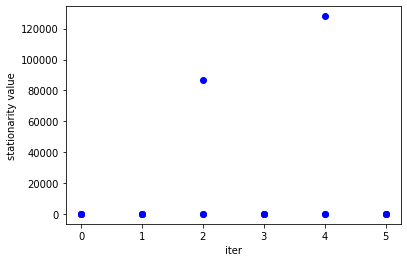

In [2]:
# from makePlot import plot
# plot(log,save_plot=True)
# plot(log,save_plot=False)

In [5]:
# log.stat_val

[1.4739484328076282,
 2.9308067182626374,
 86911.59552991863,
 9.176776981930757,
 128014.19172214148,
 10.099668162666674]

15:36:24_Jan_06_2022


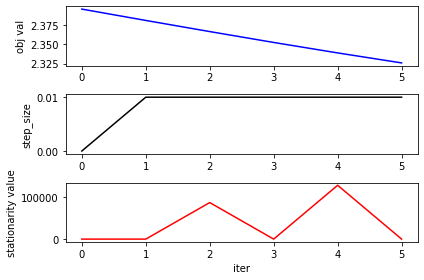

In [25]:
import os
import time
import matplotlib.pyplot as plt
iters = range(0,len(log.f))


path = '/home/buyun/Documents/GitHub/PyGRANSO/test/plots'
os.chdir(path)
ts = time.strftime('%H:%M:%S_%b_%d_%Y')
print(ts)
os.mkdir(ts)
os.chdir(ts)

fig, axs = plt.subplots(3)
# fig.suptitle('Vertically stacked subplots')

axs[0].plot(iters,log.f,'b-')
axs[0].set_ylabel('obj val')
# axs[0].xlabel('iter')

axs[1].plot(iters,log.alpha,'k-')
axs[1].set_ylabel('step_size')
# axs[1].xlabel('iter')

axs[2].plot(iters,log.stat_val,'r-')
axs[2].set_ylabel('stationarity value')
axs[2].set_xlabel('iter')

fig.tight_layout()

fig.savefig("output.png", dpi=500)




